In [1]:
# import the libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
SEED=56789
import numpy as np
np.random.seed(SEED)
import random as python_random
python_random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import LeaveOneOut, cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, make_scorer
from sklearn.metrics import roc_curve, confusion_matrix, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from pycm import ConfusionMatrix
from sklearn.preprocessing import label_binarize

from numpy import mean
from numpy import absolute
from numpy import std

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('GPCR_OPT_INT_POCK_LIG_FEAT_BIASED_DATASET.csv')
df.head()

,PDB,ECL_20-20_HBond_LIG,ECL_20-20_HBond_PROT,ECL_20-20_Hyd,ECL_23-23.50_HBond_PROT,ECL_45-45.50_HBond_LIG,ECL_45-45.50_Hyd,ECL_45-45.51_Hyd,ECL_45-45.52_Aromatic_Face/Face,ECL_45-45.52_HBond_PROT,...,poc_985,poc_986,poc_987,poc_988,poc_989,poc_99,poc_990,poc_991,poc_992,Class
0,7vdh,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,1,0
1,7vv5,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
2,7s8o,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,1,0
3,7s8n,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,0,1,1,2
4,7fih,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,1,1,1,1


In [6]:
def xgb_classifier():

    X = df.iloc[:,1:-1]
    y = df.iloc[:,-1]
    
    estimator = xgb.XGBClassifier(random_state=123, verbosity=0)
        
    print();print(format('Performing the K-Fold for XGB Classifier','*^82'))
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=5678)
    
    acc_score_skf = []
    mcc_score_skf = []
    f1_score_skf = []
    kappa_score_skf = []
    recall_score_skf = []
    precision_score_skf = []
    roc_auc_score_skf = []
    auPR_score_skf = []
    cm_score_skf = []
    
    fold_no = 1
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = estimator
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)

        acc_skf = accuracy_score(y_test, y_pred)
        mcc_skf = metrics.matthews_corrcoef(y_test, y_pred)
        f1_skf = metrics.f1_score(y_test, y_pred, average='macro')
        kappa_skf = metrics.cohen_kappa_score(y_test, y_pred)
        recall_skf = metrics.recall_score(y_test, y_pred, average='macro')
        precision_skf = metrics.precision_score(y_test, y_pred, average='macro')
        
        ytests = tf.keras.utils.to_categorical(np.array(y_test), num_classes=3)
        ytest_preds = tf.keras.utils.to_categorical(np.array(y_pred), num_classes=3)        
        roc_auc_skf = metrics.roc_auc_score(ytests, ytest_preds, average='macro')
        auPR_skf = average_precision_score(ytests, ytest_preds, average='macro')
        cm_skf = confusion_matrix(y_test, y_pred)

        print(f'confusion matrix for fold {fold_no}', confusion_matrix(y_test, y_pred))
        
        acc_score_skf.append(acc_skf)
        mcc_score_skf.append(mcc_skf)
        f1_score_skf.append(f1_skf)
        kappa_score_skf.append(kappa_skf)
        recall_score_skf.append(recall_skf)
        precision_score_skf.append(precision_skf)
        roc_auc_score_skf.append(roc_auc_skf)
        auPR_score_skf.append(auPR_skf)
        cm_score_skf.append(cm_skf)
        
        fold_no = fold_no + 1

    print();print('Statistics for K-Fold: ')
    print("Accuracy_SKF: %.4f (%.4f)" % (mean(acc_score_skf), std(acc_score_skf)))
    print("MCC_SKF: %.4f (%.4f)" % (mean(mcc_score_skf), std(mcc_score_skf)))
    print("F1_Score_SKF: %.4f (%.4f)" % (mean(f1_score_skf), std(f1_score_skf)))
    print("Recall_SKF: %.4f (%.4f)" % (mean(recall_score_skf), std(recall_score_skf)))
    print("Precision_SKF: %.4f (%.4f)" % (mean(precision_score_skf), std(precision_score_skf)))
    print("ROC_AUC_SKF: %.4f (%.4f)" % (mean(roc_auc_score_skf), std(roc_auc_score_skf)))
    print("auPR_SKF: %.4f (%.4f)" % (mean(auPR_score_skf), std(auPR_score_skf)))
    print("Confusion_Matrix_SKF:", sum(cm_score_skf))
    
    print();print(format('Performing the Test Set prediction','*^82'))
    
    X_w = df.iloc[:,0:-1]
    y_w = df.iloc[:,-1]

    X_train_w, X_test_w, y_train, y_test = train_test_split(X_w, y_w, test_size=0.2, random_state=5678, stratify=y_w)

    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    X_train = X_train_w.iloc[:,1:-1]
    X_test = X_test_w.iloc[:,1:-1]
    X_train_id = X_train_w.iloc[:,0]
    X_test_id = X_test_w.iloc[:,0]

    model_TRTS = estimator
    model_TRTS.fit(X_train, y_train)
    
    y_pred_train = model_TRTS.predict(X_train)
    y_pred_test = model_TRTS.predict(X_test)

    acc_ts = accuracy_score(y_test, y_pred_test)
    mcc_ts = metrics.matthews_corrcoef(y_test, y_pred_test)
    f1_score_ts = metrics.f1_score(y_test, y_pred_test, average='macro')
    ytests = tf.keras.utils.to_categorical(np.array(y_test), num_classes=3)
    ytest_preds = tf.keras.utils.to_categorical(np.array(y_pred_test), num_classes=3)
    roc_auc_ts = metrics.roc_auc_score(ytests, ytest_preds, average='macro',multi_class='ovr')

    auPR_ts = average_precision_score(ytests, ytest_preds, average='macro')
    cm_ts = confusion_matrix(y_test, y_pred_test)
    
    print();print('Classifier Statistics for Test: ')
    print("Accuracy_Test: %.4f" % acc_ts)
    print("MCC_Test: %.4f" % mcc_ts)
    print("f1_score_Test: %.4f" % f1_score_ts)
    print("ROC_AUC_Test:", roc_auc_ts)
    print("auPR_Test:", auPR_ts)
    print("Confusion_Matrix_Test:", cm_ts)
    print(classification_report(y_test, y_pred_test))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(ytests[:, i], ytest_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        precision = dict()
        recall = dict()
        average_precision = dict()
        
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(ytests[:, i], ytest_preds[:, i])
        average_precision[i] = average_precision_score(ytests[:, i], ytest_preds[:, i])
    
    precision["micro"], recall["micro"], _ = precision_recall_curve(ytests.ravel(), ytest_preds.ravel())
    average_precision["micro"] = average_precision_score(ytests, ytest_preds, average="micro")
    
    fig, ax = plt.subplots(1,2,figsize=(9,5))
    
    for i, classes in zip(range(3), ['Class0', 'Class1', 'Class2']):
        ax[0].plot(fpr[i], tpr[i], label=classes+'(AUC: %0.3f)' % roc_auc[i], alpha=1)
    ax[0].plot([0, 1], [0, 1],'k--')
    ax[0].set_xlim([0.0, 1.01])
    ax[0].set_ylim([0.0, 1.01])
    ax[0].set_yticks(np.arange(0, 1.1, 0.1))
    ax[0].set_xticks(np.arange(0, 1.1, 0.1))
    ax[0].set_xlabel('False Positive Rate', fontsize=14)
    ax[0].set_ylabel('True Positive Rate', fontsize=14)
    ax[0].set_title('ROC curves', fontsize=14)
    ax[0].grid(linestyle='-.', linewidth=0.7)
    ax[0].tick_params(axis="y", labelsize=12) 
    ax[0].tick_params(axis="x", labelsize=12)
    ax[0].legend(fontsize=10, loc="lower right")
        
    for i, classes in zip(range(3), ['Class0', 'Class1' , 'Class2']):
        ax[1].plot(recall[i], precision[i], label=classes+'(AUC: %0.3f)' % average_precision[i], alpha=1)     
    
    ax[1].plot([0, 1], [1, 0],'k--')
    ax[1].set_xlim([0.0, 1.01])
    ax[1].set_ylim([0.0, 1.01])
    ax[1].set_yticks(np.arange(0, 1.1, 0.1))
    ax[1].set_xticks(np.arange(0, 1.1, 0.1))
    ax[1].set_xlabel('Recall', fontsize=14)
    ax[1].set_ylabel('Precision', fontsize=14)
    ax[1].set_title('Precision-Recall curves (micro avg :{0:0.3f})'.format(average_precision["micro"]), fontsize=14)
    ax[1].grid(linestyle='-.', linewidth=0.7)
    ax[1].tick_params(axis="y", labelsize=12) 
    ax[1].tick_params(axis="x", labelsize=12)
    ax[1].legend(fontsize=10, loc="lower left")
    plt.tight_layout()
    
    print();print(format('Performing the Bias-Variance Decomposition Analysis ','*^82'))    
    
    # Bias-Variance Decomposition
    
    X = df.iloc[:,1:-1]
    y = df.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5678, stratify=y)
    
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model_TRTS, X_train, y_train, 
                                                            X_test, y_test,
                                                            loss='0-1_loss',random_seed=123)
    print();print('Bias Variance Decomposition Analysis: ')
    print('Average expected loss: %.3f' % avg_expected_loss)
    print('Average bias: %.3f' % avg_bias)
    print('Average variance: %.3f' % avg_var)


*********************Performing the K-Fold for XGB Classifier*********************
confusion matrix for fold 1 [[6 0 0]
 [1 2 0]
 [0 0 1]]
confusion matrix for fold 2 [[6 0 0]
 [0 3 0]
 [1 0 0]]
confusion matrix for fold 3 [[6 0 0]
 [0 3 0]
 [0 0 1]]
confusion matrix for fold 4 [[3 1 1]
 [0 4 0]
 [0 0 1]]
confusion matrix for fold 5 [[4 0 1]
 [1 3 0]
 [1 0 0]]
confusion matrix for fold 6 [[5 0 0]
 [1 3 0]
 [1 0 0]]
confusion matrix for fold 7 [[5 0 0]
 [0 3 0]
 [0 0 1]]
confusion matrix for fold 8 [[3 2 0]
 [0 3 0]
 [1 0 0]]
confusion matrix for fold 9 [[5 0 0]
 [0 3 0]
 [1 0 0]]
confusion matrix for fold 10 [[5 0 0]
 [0 3 0]
 [0 0 1]]

Statistics for K-Fold: 
Accuracy_SKF: 0.8656 (0.1152)
MCC_SKF: 0.7764 (0.1918)
F1_Score_SKF: 0.7517 (0.1997)
Recall_SKF: 0.7722 (0.1893)
Precision_SKF: 0.7526 (0.2061)
ROC_AUC_SKF: 0.8441 (0.1255)
auPR_SKF: 0.7419 (0.1989)
Confusion_Matrix_SKF: [[48  3  2]
 [ 3 30  0]
 [ 5  0  5]]

************************Performing the Test Set prediction*************

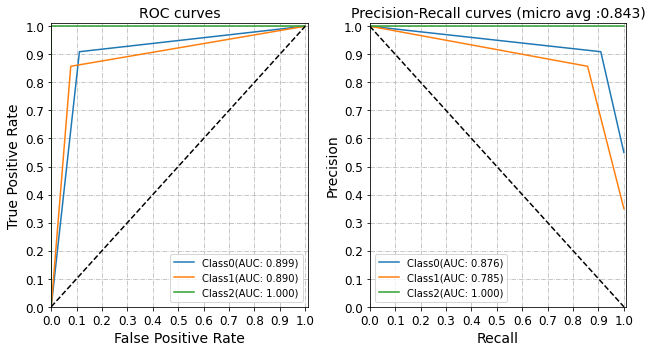

In [16]:
xgb_classifier()